<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced MetPy: Isentropic Analysis</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Objectives
1. <a href="#download">Download GFS output from TDS</a>
1. <a href="#interpolation">Interpolate GFS output to an isentropic level</a>
1. <a href="#ascent">Calculate regions of isentropic ascent and descent</a>

<a name="download"></a>
## Downloading GFS Output
First we need some grids of values to work with. We can do this by dowloading information from the latest run of the GFS available on Unidata's THREDDS data server. First we access the catalog for the half-degree GFS output, and look for the dataset called the "Best GFS Half Degree Forecast Time Series". This dataset combines multiple sets of model runs to yield a time series of output with the shortest forecast offset.

In [1]:
from siphon.catalog import TDSCatalog

cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
best = cat.datasets['Best GFS Half Degree Forecast Time Series']

Next, we set up access to request subsets of data from the model. This uses the NetCDF Subset Service (NCSS) to make requests from the GRIB collection and get results in netCDF format.

In [2]:
subset_access = best.subset()
query = subset_access.query()

Let's see what variables are available. Instead of just printing `subset_access.variables`, we can ask Python to only display variables that end with "isobaric", which is how the TDS denotes GRIB fields that are specified on isobaric levels.

In [3]:
sorted(v for v in subset_access.variables if v.endswith('isobaric'))

['5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Cloud_mixing_ratio_isobaric',
 'Geopotential_height_isobaric',
 'Graupel_snow_pellets_isobaric',
 'Ice_water_mixing_ratio_isobaric',
 'Icing_Severity_isobaric',
 'Ozone_Mixing_Ratio_isobaric',
 'Rain_mixing_ratio_isobaric',
 'Relative_humidity_isobaric',
 'Snow_mixing_ratio_isobaric',
 'Temperature_isobaric',
 'Total_cloud_cover_isobaric',
 'Vertical_velocity_geometric_isobaric',
 'Vertical_velocity_pressure_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric']

Now we put together the "query"--the way we ask for data we want. We give ask for a wide box of data over the U.S. for the time step that's closest to now. We also request temperature, height, winds, and relative humidity. By asking for netCDF4 data, the result is compressed, so the download is smaller.

In [4]:
from datetime import datetime
query.time(datetime.utcnow())
query.variables('Temperature_isobaric', 'Geopotential_height_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric',
                'Relative_humidity_isobaric')
query.lonlat_box(west=-130, east=-50, south=10, north=60)
query.accept('netcdf4')

var=Relative_humidity_isobaric&var=Temperature_isobaric&var=v-component_of_wind_isobaric&var=Geopotential_height_isobaric&var=u-component_of_wind_isobaric&time=2020-09-04T15%3A38%3A26.105980&west=-130&east=-50&south=10&north=60&accept=netcdf4

Now all that's left is to actually make the request for data:

In [5]:
nc = subset_access.get_data(query)

Open the returned netCDF data using XArray:

In [6]:
from xarray.backends import NetCDF4DataStore
import xarray as xr
ds = xr.open_dataset(NetCDF4DataStore(nc))

<a name="interpolation"></a>
## Isentropic Interpolation

Now let's take what we've downloaded, and use it to make an isentropic map. In this case, we're interpolating from one vertical coordinate, pressure, to another: potential temperature. MetPy has a function `isentropic_interpolation` that can do this for us. First, let's start with a few useful imports.

In [7]:
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np

Let's parse out the metadata for the isobaric temperature and get the projection information. We also index with 0 to get the first, and only, time:

In [8]:
ds = ds.metpy.parse_cf()
temperature = ds['Temperature_isobaric'][0]

In [9]:
data_proj = temperature.metpy.cartopy_crs

Let's pull out the grids out into some shorter variable names.

In [10]:
lat = temperature.metpy.y
lon = temperature.metpy.x

# Need to adjust units on humidity because '%' causes problems
ds['Relative_humidity_isobaric'].attrs['units'] = 'percent'

rh = ds['Relative_humidity_isobaric'][0]
height = ds['Geopotential_height_isobaric'][0]
u = ds['u-component_of_wind_isobaric'][0]
v = ds['v-component_of_wind_isobaric'][0]

In [11]:
# Can have different vertical levels for wind and thermodynamic variables
# Find and select the common levels
press = temperature.metpy.vertical
common_levels = np.intersect1d(press, u.metpy.vertical)
temperature = temperature.metpy.sel(vertical=common_levels)
u = u.metpy.sel(vertical=common_levels)
v = v.metpy.sel(vertical=common_levels)

# Get common pressure levels as a data array
press = press.metpy.sel(vertical=common_levels)

Next, we perform the isentropic interpolation. At a minimum, this must be given one or more isentropic levels, the 3-D temperature field, and the pressure levels of the original field; it then returns the 3D array of pressure values (2D slices for each isentropic level). You can also pass addition fields which will be interpolated to these levels as well. Below, we interpolate the winds (and pressure) to the 320K isentropic level:

In [12]:
isen_level = np.array([320]) * units.kelvin
isen_press, isen_u, isen_v = mpcalc.isentropic_interpolation(isen_level, press,
                                                             temperature, u, v)

Let's plot the results and see what it looks like:

In [13]:
# Need to squeeze() out the size-1 dimension for the isentropic level
isen_press = isen_press.squeeze()
isen_u = isen_u.squeeze()
isen_v = isen_v.squeeze()

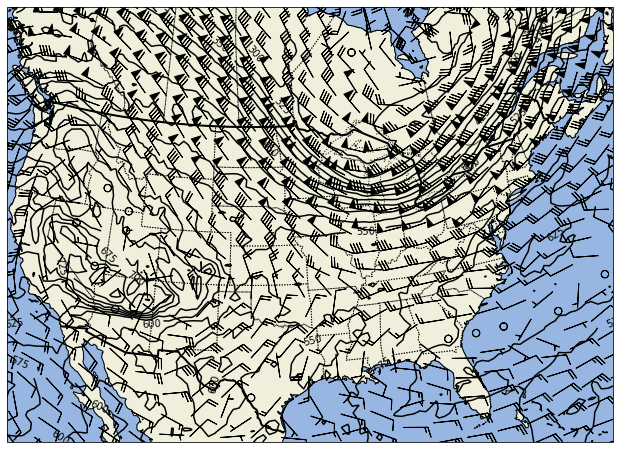

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a plot and basic map projection
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))

# Contour the pressure values for the isentropic level. We keep the handle
# for the contour so that we can have matplotlib label the contours
levels = np.arange(300, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj,
                  colors='black', levels=levels)
cntr.clabel(fmt='%d')

# Set up slices to subset the wind barbs--the slices below are the same as `::5`
# We put these here so that it's easy to change and keep all of the ones below matched
# up.
lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 3)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lat_slice, lon_slice].to('knots').magnitude,
         isen_v[lat_slice, lon_slice].to('knots').magnitude,
         transform=data_proj, zorder=2)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.set_extent((-120, -70, 25, 55), crs=data_proj)

<div class="alert alert-success">
    <b>EXERCISE</b>:
    
Let's add some moisture information to this plot. Feel free to choose a different isentropic level.
    
 <ul>
     <li>Calculate the mixing ratio (using the appropriate function from mpcalc).</li>
     <li>Call isentropic_interpolation with mixing ratio. You should copy the one from above and add mixing ratio to the call so that it interpolates everything.</li>
     <li>contour (in green) or contourf your moisture information on the map alongside pressure.</li>
</ul>
    
You'll want to refer to the [MetPy API documentation](https://unidata.github.io/MetPy/latest/api/index.html) to see what calculation functions would help you.
</div>

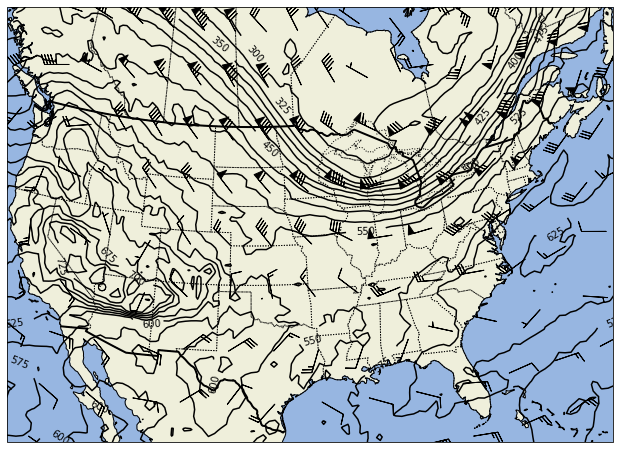

In [15]:
# Needed to make numpy broadcasting work between 1D pressure and other 3D arrays
# Use .metpy.unit_array to get numpy array with units rather than xarray DataArray
pressure_for_calc = press.metpy.unit_array[:, None, None]  

#
# YOUR CODE: Calculate mixing ratio using something from mpcalc
#

# Take the return and convert manually to units of 'dimenionless'
#mixing.ito('dimensionless')

#
# YOUR CODE: Interpolate all the data
#

# Squeeze the returned arrays
#isen_press = isen_press.squeeze()
#isen_mixing = isen_mixing.squeeze()
#isen_u = isen_u.squeeze()
#isen_v = isen_v.squeeze()

# Create Plot -- same as before
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))

levels = np.arange(300, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj,
                  colors='black', levels=levels)
cntr.clabel(fmt='%d')

lon_slice = slice(None, None, 8)
lat_slice = slice(None, None, 8)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lat_slice, lon_slice].to('knots').magnitude,
         isen_v[lat_slice, lon_slice].to('knots').magnitude,
         transform=data_proj, zorder=2)

#
# YOUR CODE: Contour/Contourf the mixing ratio values
#


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')

ax.set_extent((-120, -70, 25, 55), crs=data_proj)

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


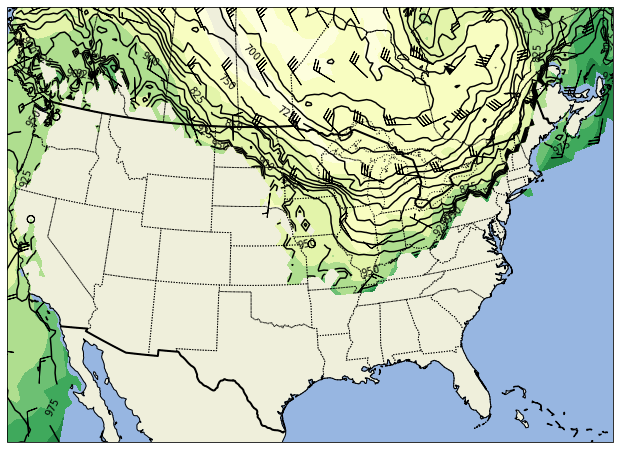

In [16]:
# %load solutions/mixing.py

# Cell content replaced by load magic replacement.
# Needed to make numpy broadcasting work between 1D pressure and other 3D arrays
# Use .metpy.unit_array to get numpy array with units rather than xarray DataArray
pressure_for_calc = press.metpy.unit_array[:, None, None]  

# Calculate mixing ratio using something from mpcalc
mixing = mpcalc.mixing_ratio_from_relative_humidity(rh, temperature, pressure_for_calc)


# Take the return and convert manually to units of 'dimenionless'
mixing.ito('dimensionless')


# Interpolate all the data
isen_level = np.array([295]) * units.kelvin
ret = mpcalc.isentropic_interpolation(isen_level, press, temperature, mixing, u, v)
isen_press, isen_mixing, isen_u, isen_v = ret


# Squeeze the returned arrays
isen_press = isen_press.squeeze()
isen_mixing = isen_mixing.squeeze()
isen_u = isen_u.squeeze()
isen_v = isen_v.squeeze()


# Create Plot -- same as before
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))

levels = np.arange(300, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj,
                  colors='black', levels=levels)
cntr.clabel(fmt='%d')


lon_slice = slice(None, None, 8)
lat_slice = slice(None, None, 8)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lat_slice, lon_slice].to('knots').magnitude,
         isen_v[lat_slice, lon_slice].to('knots').magnitude,
         transform=data_proj, zorder=2)


# Contourf the mixing ratio values
mixing_levels = [0.001, 0.002, 0.004, 0.006, 0.010, 0.012, 0.014, 0.016, 0.020]
ax.contourf(lon, lat, isen_mixing, transform=data_proj,
            levels=mixing_levels, cmap='YlGn')


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
ax.add_feature(cfeature.STATES, linestyle=':')


ax.set_extent((-120, -70, 25, 55), crs=data_proj)


<a name="ascent"></a>
## Calculating Isentropic Ascent

Air flow across isobars on an isentropic surface represents vertical motion. We can use MetPy to calculate this ascent for us.

Since calculating this involves taking derivatives, first let's smooth the input fields using a gaussian_filter.

In [17]:
isen_press = mpcalc.smooth_gaussian(isen_press.squeeze(), 9)
isen_u = mpcalc.smooth_gaussian(isen_u.squeeze(), 9)
isen_v = mpcalc.smooth_gaussian(isen_v.squeeze(), 9)

Next, we need to take our grid point locations which are in degrees, and convert them to grid spacing in meters--this is what we need to pass to functions taking derivatives.

In [18]:
# Use .values because we don't care about using DataArray
dx, dy = mpcalc.lat_lon_grid_deltas(lon.values, lat.values)

Now we can calculate the isentropic ascent. $\omega$ is given by:

$$\omega = \left(\frac{\partial P}{\partial t}\right)_\theta + \vec{V} \cdot \nabla P + \frac{\partial P}{\partial \theta}\frac{d\theta}{dt}$$

Note, the second term of the above equation is just pressure advection (negated). Therefore, we can use MetPy to calculate this as:

In [19]:
lift = -mpcalc.advection(isen_press, [isen_u, isen_v], [dx, dy], dim_order='yx')

<div class="alert alert-success">
    <b>EXERCISE</b>:
Use contourf to plot the isentropic lift alongside the isobars and wind barbs. You probably want to convert the values of lift to microbars/s.
</div>

In [20]:
# YOUR CODE GOES HERE

<div class="alert alert-info">
    <b>SOLUTION</b>
</div>

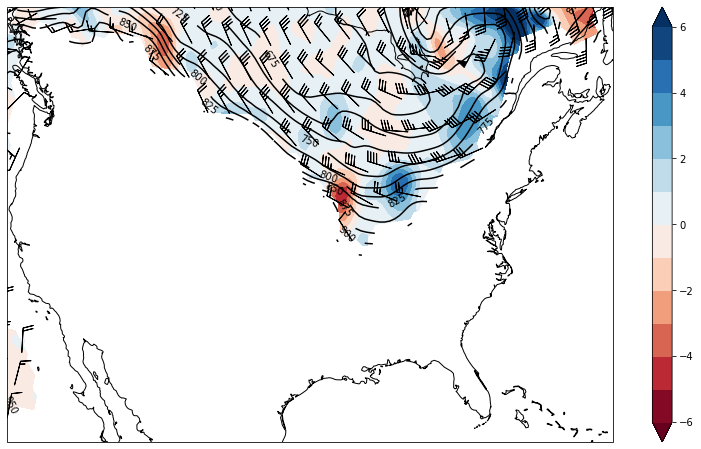

In [21]:
# %load solutions/lift.py

# Cell content replaced by load magic replacement.
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-100))
ax.add_feature(cfeature.COASTLINE)

levels = np.arange(300, 1000, 25)
cntr = ax.contour(lon, lat, isen_press, transform=data_proj, colors='black', levels=levels)
cntr.clabel(fmt='%d')


lon_slice = slice(None, None, 5)
lat_slice = slice(None, None, 5)
ax.barbs(lon[lon_slice], lat[lat_slice],
         isen_u[lon_slice, lat_slice].to('knots').magnitude,
         isen_v[lon_slice, lat_slice].to('knots').magnitude,
         transform=data_proj, zorder=2)


levels = np.arange(-6, 7)
cs = ax.contourf(lon, lat, lift.to('microbar/s'), levels=levels, cmap='RdBu',
                 transform=data_proj, extend='both')
plt.colorbar(cs)


ax.set_extent((-120, -70, 25, 55), crs=data_proj)
